In [1]:
import requests
import re


#  Lookup arxiv


Do an **arxiv** search for the title and attempt to return the abstract

ss = 'https://arxiv.org/search/?query=The+Grunwald+problem+and+homogeneous+spaces+with+non-solvable+stabilisers&searchtype=title&abstracts=show&order=-announced_date_first&size=50'

In [6]:
pp = re.compile('<span class="abstract-full.*?>(.*?)<a', re.DOTALL)

def get_arxiv(title):
    
    s_title = '+'.join(title.split() )
    user_agent = {'User-Agent': "Mozilla/5.0 (X11; CrOS x86_64 13099.62.0) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/84.0.4147.83 Safari/537.36"}
    
    params = {"query": s_title,
              "searchtype" : "title",
              "abstract" : "show",
              "order" : "-announced_date_first",
              "size" : "50"}
    
    r = requests.get(url= "https://arxiv.org/search",
                 headers = user_agent,
                 params = params
                )
    if r.status_code == 200 :
        return r
    else:
        return None

## Usage 

In [7]:
tt = "Right-angled Artin subgroups and free products in one-relator groups"
tt = 'Skoda-Zeriahi type integrability and entropy compactness for some measure with $L^1$-density by '

xx = get_arxiv(tt)

print(f'who would be a good referee for this article:\n\nTitle: {tt}\n\n {pp.search(xx.text).group(1).strip()}')

who would be a good referee for this article:

Title: Skoda-Zeriahi type integrability and entropy compactness for some measure with $L^1$-density by 

 In this paper, we prove the Skoda-Zeriahi type integrability theorem with respect to some measure with $L^1$-density. In addition, we introduce the log-log threshold in order to detect singularities of Kähler potentials. We prove the positivity of the integrability threshold for such a measure and Kähler potentials with uniform log-log threshold. As an application, we prove the entropy compactness theorem for a family of potential functions of Poincaré type Kähler metrics with uniform log-log threshold. The Ohsawa-Takegoshi $L^2$-extension theorem and Skoda-Zeriahi&#39;s integrability theorem play a very important role in this paper.


# MSC classification

easily scraped as follows

In [2]:
import re
import requests
url = 'https://cran.r-project.org/web/classifications/MSC.html'
r = requests.get(url=url)
with open('./MSC Classification Codes.mhtml','w') as fp:
    fp.write(r.text)

In [3]:
with open('./MSC Classification Codes.mhtml','r') as fp:
    data = fp.read()

01A72: Schools of mathematics</li>

In [4]:
kpp = re.compile(r'(\d{2}[A-Z]\d{2}):\s+(.*?)<')
codes = dict(kpp.findall(data))

In [5]:
codes['11G05']

'Elliptic curves over global fields'

---

# Mining a PDF for references 


In [9]:
import os
from io import StringIO
import re
from pdfminer.pdfinterp import PDFResourceManager, PDFPageInterpreter
from pdfminer.converter import TextConverter
from pdfminer.layout import LAParams
from pdfminer.pdfpage import PDFPage


def pdf_to_text(path):
    '''Extract text from pdf documents
    '''

    manager = PDFResourceManager()
    retstr = StringIO()
    layout = LAParams(all_texts=False, detect_vertical=True)
    device = TextConverter(manager, retstr, laparams=layout)
    interpreter = PDFPageInterpreter(manager, device)
    with open(path, 'rb') as filepath:
        for page in PDFPage.get_pages(filepath, check_extractable=True):
            interpreter.process_page(page)
    text = retstr.getvalue()
    device.close()
    retstr.close()
    return text

In [57]:
import os
base = os.environ['HOME']  + '/'
pdfs = [_ for _ in os.listdir(base) if _[-3:] == 'pdf']
fn = base + pdfs[-2]
tt = pdf_to_text(fn)

In [58]:
tt[:1000]

'SOME GEOMETRIC APPLICATIONS OF THE DISCRETE HEAT FLOW\n\nALEXANDROS ESKENAZIS\n\nAbstract. We present two geometric applications of heat ﬂow methods on the discrete hyper-\ncube {−1,1}n. First, we prove that if X is a ﬁnite-dimensional normed space, then the bi-Lipschitz\ndistortion required to embed {−1,1}n equipped with the Hamming metric into X satisﬁes\n\n(cid:16){−1,1}n(cid:17) (cid:38) sup\n\ncX\n\np∈[1,2]\n\nn\n\nTp(X)min{n,dim(X)}1/p\n\n,\n\nwhere Tp(X) is the Rademacher type p constant of X. This estimate yields a mutual reﬁnement\nof distortion lower bounds which follow from works of Oleszkiewicz (1996) and Ivanisvili, van\nHandel and Volberg (2020) for low-dimensional spaces X. The proof relies on an extension of\nan important inequality of Pisier (1986) on the biased hypercube combined with an application\nof the Borsuk–Ulam theorem from algebraic topology. Secondly, we introduce a new metric\ninvariant called metric stable type as a functional inequality on the discrete h

In [23]:
#a  reference in the biblio has the form
#[number](space)(Initial)(text up top next [)
rp = re.compile(r'(\[\d+\]\s+[A-Z][^\[]*)',re.DOTALL)
dp = re.compile(r'\d{4}')

In [59]:
#tt = re.sub(r'\[','\[\[',tt)
raw_refs = rp.findall(tt)
unhyphenated = [re.sub('\-[\n]','',_) for _ in  raw_refs[:] ]
clean_refs = [re.sub('[\n]+',' ',_) for _ in  unhyphenated ]
ref_texts = '\n\n'.join(clean_refs)
ref_texts = re.sub('[¨]','',ref_texts)
nums = [dp.findall(_) for _ in clean_refs]
dd = [ [x for x in _ if 1900 < int(x) < 2024] for _ in nums]
dd = [ _ for _ in dd if _ ]
dd = [ max(_) for _ in dd]

In [60]:
px = re.compile('\[\d+\].*?ESKENAZIS.*')
px.findall(ref_texts.upper())

['[16] DARIO CORDERO-ERAUSQUIN AND ALEXANDROS ESKENAZIS. DISCRETE LOGARITHMIC SOBOLEV INEQUALITIES IN BANACH SPACES. PREPRINT AVAILABLE AT HTTPS://ARXIV.ORG/ABS/2304.03878, 2023. ',
 '[17] DARIO CORDERO-ERAUSQUIN AND ALEXANDROS ESKENAZIS. TALAGRAND’S INFLUENCE INEQUALITY REVISITED. ANAL. PDE, 16(2):571–612, 2023. ',
 '[22] ALEXANDROS ESKENAZIS. ON PISIER’S INEQUALITY FOR UMD TARGETS. CANAD. MATH. BULL., 64(2):282–291, 2021. ',
 '[23] ALEXANDROS ESKENAZIS, MANOR MENDEL, AND ASSAF NAOR. DIAMOND CONVEXITY: A BIFURCATION IN THE RIBE PROGRAM. PREPRINT, 2023. ',
 '[69] SANTOSH S. VEMPALA. THE RANDOM PROJECTION METHOD, VOLUME 65 OF DIMACS SERIES IN DISCRETE MATHEMATICS AND THEORETICAL COMPUTER SCIENCE. AMERICAN MATHEMATICAL SOCIETY, PROVIDENCE, RI, 2004. WITH A FOREWORD BY CHRISTOS H. PAPADIMITRIOU. CNRS, INSTITUT DE MATHÉMATIQUES DE JUSSIEU, SORBONNE UNIVERSITÉ, FRANCE AND TRINITY COLLEGE, UNIVERSITY OF CAMBRIDGE, UK. EMAIL ADDRESS: ALEXANDROS.ESKENAZIS@IMJ-PRG.FR, AE466@CAM.AC.UK 18 \x0c']

---

# Do stats on the dates 

In [26]:
import matplotlib.pyplot as plt

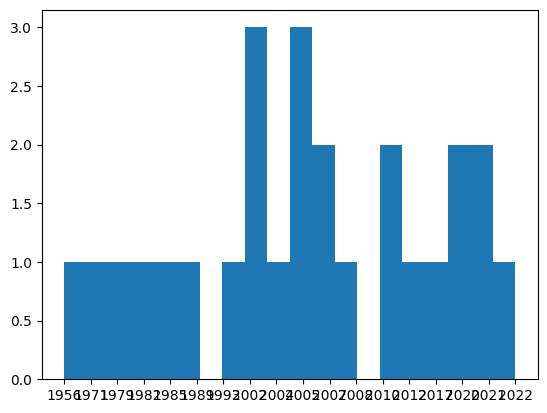

In [36]:
dd.sort()
plt.hist(dd, bins = 20);

In [2]:

1 + 1

2

In [3]:
ss = '''

# Nouveau #
2023128 ONNIS https://aif.centre-mersenne.org/ojs/workflow/index/2023128/1
A FAMILY OF HIGHER GENUS COMPLETE MINIMAL SURFACES THAT
INCLUDES THE COSTA-HOFFMAN-MEEKS ONE
CL : Avis William H. Meeks meeks@math.umass.edu ? Ou Joaquin Perez jperez@ugr.es ?
LF: Je rajouterais aussi avis à Gérard Besson, Fernando Coda-Marques, et parmi les potentiels referees Laurent Hauswirth, Laurent Mazet
EP: G. Besson

2023141 ZHAO https://aif.centre-mersenne.org/ojs/workflow/index/2023141/1
VL: Denis Benois, Laurent Berger, Xavier Caruso sont cites. L'article est une partie d'une these sous la direction d'Olivier Brinon. 
EP: L. Berger me semble une bonne idée.

2023142 YGER https://aif.centre-mersenne.org/ojs/workflow/index/2023142/1
AJ: Problème d‘analyse harmonique mal motivé par des considérations de mécanique quantique. 
ER: Daniel Alpay (alpay@chapman.edu)
EP: Alpay

2023143 RIVAS https://aif.centre-mersenne.org/ojs/workflow/index/2023143/1
Quelques contributions aux équations du champ lagrangien k-contact, symétries et lois de dissipation         
GM : refus TS
CL : OK
LF:ok
EP: refus TS

2023144 CARBONNE https://aif.centre-mersenne.org/ojs/workflow/index/2023144/1
VL: Bertrand, quel est ton avis?
EP: Effectivement c'est pour BR.
EP: BR

2023145 JOSEPH https://aif.centre-mersenne.org/ojs/workflow/index/2023145/1
Isometric orbit equivalence for probability-measure preserving actions
CL : étudiant de Gaboriau thèse juin 2022, rapporteurs rapporteurs Yair Glasner, Roman Sauer.
Avis François Dahmani, Camille Horbez ou Vincent Guirardel ?
EP: F. Dahmani

2023146 KALFAGIANNI https://aif.centre-mersenne.org/ojs/workflow/index/2023146/1
GM : avis Futer, Schleimer
CL : Peut-être un peu spécialisé ? Futer et Schleimer sont remerciés dans l'introduction.
On peut aussi demander un avis à Qingtao Chen qc217@nyu.edu
LF: D'accord avec Christine
EP: Qing Tao Chen (en gardant en tête le coté TS)

2023147 TIANSHU https://aif.centre-mersenne.org/ojs/workflow/index/2023147/1
SD : une "preuve" élémentaire de la conjecture de Beal ... refus
CL : OK
EP: Refus niveau.

2023148 ARAMAYONA https://aif.centre-mersenne.org/ojs/workflow/index/2023148/1
GM : avis Leininger 
LF: la bibliographie manque; demande avis/rapport  Kai-Uwe Bux, Anne Lonjou
CL : Commencer par demander une révision avec la biblio.
EP: Bonne version de l'article. Puis Kai-Uwe Bux, Anne Lonjou

2023149 ZHAO https://aif.centre-mersenne.org/ojs/workflow/index/2023149/1
Increasing stability estimates for the inverse elastic scattering         
AJ : refus trop spécialisé
ER: OK
EP: Refus TS.

2023151 SHEIKH https://aif.centre-mersenne.org/ojs/workflow/index/2023151/1
GM : refus niveau 
SD : le but est d'écrire tout entier comme somme de fractions " in an attractive manner" ... refus niveau
GM OK
CL : OK
EP: Refus niveau.

2023155 KONIECZNY https://aif.centre-mersenne.org/ojs/workflow/index/2023155/1
Pisot numbers, Salem numbers, and generalised polynomials         
GM : avis Adamczewski ?
CL : Il est coauteur récent (2022) avec l'un des auteurs.
EP: Chris Smyth (Edinbourgh)
DH: Or possibly Toufik Zaïmi or Aimo Hinkkanen.
EP: C. Smyth puis Taïmi Hinkkanen

2023159 XU https://aif.centre-mersenne.org/ojs/workflow/index/2023159/1
Generalized Suita Conjectures with Jets and Weights         
CL : Je n'y connais rien, mais ça me parait trop spécialisé.
EP: fonctions psh opinion de V. Guedj?
EP: V. Guedj ou T. Zeriahi

2023160 KIM https://aif.centre-mersenne.org/ojs/workflow/index/2023160/1
RV : nouvelle version de 2021025, refusé après rapport de Zhang           
GM : OK           
EP: Je ne trouve pas trace dans mes archives qu'on est laissé une invitation 
à resoumettre. Sauf décision contraire, je compte écrire une lettre claire disant
que notre refus est définitif.

2023161 LASTRA https://aif.centre-mersenne.org/ojs/workflow/index/2023161/1
On sequences preserving $q-$Gevrey asymptotic expansions         
AJ : avis à Tanguy Rivoal (si ça a du sens) ?
ER: OK, sinon Julien Roques ? Thomas Dreyfus ?
EP: T. Rivoal pour commencer.

2023162 CHENERY https://aif.centre-mersenne.org/ojs/workflow/index/2023162/1
ML: c'est un étudiant de thériault, on pourrait demander à J. Scherer?
CL : OK
LF:ok
EP: Scherer.

2023170 CIELIEBAK https://aif.centre-mersenne.org/ojs/workflow/index/2023170/1
ML: Bruno Vallette, Manuel Rivera
CL : OK
EP: B. Vallette, M. Rivera

2023171 DUCROS https://aif.centre-mersenne.org/ojs/workflow/index/2023171/1
Utilisation de l'aplatissement en géométrie de Berkovich 
EP: On pourrait demander un avis à Antoine Chambert-Loir sinon M. Jonsson (Michigan).
DH: Other possibilities include Michael Temkin and Jérôme Poineau.
EP: ACL sinon Berkovich (?)

2023172 BRANCHEREAU https://aif.centre-mersenne.org/ojs/workflow/index/2023172/1
Une borne supérieure sur le dénominateur de la cohomologie d'Eisenstein sur des variétés de Bianchi         
VL: Tobias Berger, Nicolas Bergeron et  Pierre Charollois sont cites. 
EP: T. Berger puis N. Bergeron ou P. Charollois.

2023173 KONCKI https://aif.centre-mersenne.org/ojs/workflow/index/2023173/1
SD : avis Vasserot
EP: Vasserot

2023175 ALLAME https://aif.centre-mersenne.org/ojs/workflow/index/2023175/1
GM :  simple proof for Collatz conjecture. refus
CL : OK
EP: Refus niveau.

2023177 VOGEL https://aif.centre-mersenne.org/ojs/workflow/index/2023177/1
A Topological Quantum Field Theory for Character Varieties of Non-orientable Surfaces         
CL : On peut demander l'avis d'Emmanuel Letellier, mais vu le backlog, ça me parait un peu trop spécialisé.
LF: Ok avec Christine
EP: Refus TS

2023178 BEDARIDE https://aif.centre-mersenne.org/ojs/workflow/index/2023178/1
The measure transfer for subshifts induced by a morphism of free monoids   
ER: avis François Dahmani ? Ou Pierre Dehornoy ?      
EP: ou E. Lanneau.
GM : plutot Lanneau mais je trouve limite TS
EP: E. Lanneau

2023180 MARGALIT https://aif.centre-mersenne.org/ojs/workflow/index/2023180/1
GM: c'est une resoumission, https://aif.centre-mersenne.org/ojs/workflow/index/2022167/3
ML: on peut l'envoyer au même référée pour un avis rapide?
EP: oui.
DH: I agree.
EP: Dernier rapporteur Meneses (?)

2023181 RODRIGUEZ FANLO https://aif.centre-mersenne.org/ojs/workflow/index/2023181/1
VL: demander un avis rapide et une idee de rapporteur a Breuillard? 
EP: OK ou P. Eleftheriou  (Leeds) ou ?? (voir avec BR aussi)

2023182 INAYAMA https://aif.centre-mersenne.org/ojs/workflow/index/2023182/1
SD : avis M. Paun
EP:  H. Guenancia.

2023183 Martynchuk https://aif.centre-mersenne.org/ojs/workflow/index/2023183/1
GM : avis Tien Zung
EP: T.  Zung

2023184 MAEDA https://aif.centre-mersenne.org/ojs/workflow/index/2023184/1
SD : l'auteur étudie la dimension de Kodaira de certains quotients de la boule sous de multiples hypothèses qui ne sont pas discutées. Refus TS à mon avis.
EP: refus TS.

2023185 SIRE https://aif.centre-mersenne.org/ojs/workflow/index/2023185/1
Noyau de la chaleur pour le complexe de Rumin et formule de Calderon 
ER: avis Pansu ? Pour un rapport, Pierre Albin ?   
EP: Pansu 

2023186 TADANO https://aif.centre-mersenne.org/ojs/workflow/index/2023186/1
The New Compactness Criteria via $m$-Bakry--\'{E}mery Ricci Curvatures of Exponential Decay
ER: avis Hervé Pajot, ou Gilles Carron
EP: HP

2023187 VIAL https://aif.centre-mersenne.org/ojs/workflow/index/2023187/1
SD : avis MB
EP: Conrad .

2023188 BRUIN https://aif.centre-mersenne.org/ojs/workflow/index/2023188/1 
Comptage des points rationnels sur les espaces projectifs pondérés sur les corps de nombres    
EP: Attente rapport d'Emmanuel Peyre (refus).  
DH: While it is often interesting to count objects of bounded height, this paper seems rather narrow and technical, and a minor improvement on prior results. 
EP: refus avec rapport de EP.

2023189 JABBARI https://aif.centre-mersenne.org/ojs/workflow/index/2023189/1
VL: refus TS?
EP: Refus TS

2023190 VERREAULT https://aif.centre-mersenne.org/ojs/workflow/index/2023190/1
VL: demander avis a Logunov ou  Malinnikova (tous les deux  excellents, invites a l'ICM 2018)? 
EP: Malinnikova, Logunov

2023191 ZHANG https://aif.centre-mersenne.org/ojs/workflow/index/2023191/1
VL: refus TS ou avis rapide Colette Meoglin? 
EP: refus TS/

2023192 LANG https://aif.centre-mersenne.org/ojs/workflow/index/2023192/1
ML: Camille Laurent-Gengoux
CL : Ok pour un avis à Camille Laurent-Gengoux
EP: Laurent-Gengouz.

2023193 ETESSE https://aif.centre-mersenne.org/ojs/workflow/index/2023193/1
SD : 
EP: SD ?? Lazarsfeld ?
EP: Rufus TS.
    
2023194 KANO https://aif.centre-mersenne.org/ojs/workflow/index/2023194/1
Train track combinatorics and cluster algebras         
CL : Avis Goncharov, Nathan Reading nreadin@ncsu.edu ou Linhui Shen lhshen.math@gmail.com ?
Ou encore Claire Amiot ou Pierre-Guy Plamondon ?
LF: Sujet très proche de la soumission d'Ishibashi, pour laquelle nous n'avons toujours pas de referee  
GM : d'accord avec LF on peut essayer Shen 
EP: Shen puis suggestion C. Amiot 


2023195 WU https://aif.centre-mersenne.org/ojs/workflow/index/2023195/1
SD : il s'agit d'une courte note qui étudie la (semi)stabilité de certains fibrés par des méthodes très très classiques sans véritable application. Refus TS
EP: Refus TS

2023196 YOKOYAMA https://aif.centre-mersenne.org/ojs/workflow/index/2023196/1
On low-codimensional decompositions    
GM : refus TS
LF:ok
EP: Refus TS.

2023197 IRIARTE https://aif.centre-mersenne.org/ojs/workflow/index/2023197/1
SD : avis C. Favre
EP: avis Favres

2023202 DENISI https://aif.centre-mersenne.org/ojs/workflow/index/2023202/1
SD : rapport D. Huybrechts (situation éditoriale "compliquée")
EP: rapport Huybrechts.

2023203 FONIQI https://aif.centre-mersenne.org/ojs/workflow/index/2023203/1
Subgroups of even Artin groups of FC-type         
CL : Avis Thomas Haettel ou refus TS ?
GM : ou Godelle eventuellement
EP: opinion BR

2023204 TREFFINGER https://aif.centre-mersenne.org/ojs/workflow/index/2023204/1
VL: c'est tres loin de mon usage des filtrations de  Harder-Narasimhan, je n'ai pas d'avis sur cet article.  
EP. T. Bridgeland ? C'est très catégorique
DH: Possibly Alfonso Zamora or Indranil Biswas.
EP: Alfonso Zamora

2023205 MUNOZ CASTANEDA https://aif.centre-mersenne.org/ojs/workflow/index/2023205/1
SUR LA SOUS-ALGÈBRE DES ÉLÉMENTS INVARIANTS      
EP: Demander à Michel Brion.   
EP: MB

2023206 MARZUOLA https://aif.centre-mersenne.org/ojs/workflow/index/2023206/1
UNIFORM UPPER BOUNDS ON COURANT SHARP NEUMANN EIGENVALUES OF CHAIN DOMAINS
ER: Alexandre Girouard
EP: Girouard a un papier soumis. P. Bérard.
     
2023209 FETCU https://aif.centre-mersenne.org/ojs/workflow/index/2023209/1
Segre embedding and biharmonicity         
SD : refus TS ? (qu'en pensent les géométres ?) Nouveaux exemples de variétés bi-harmoniques, aucune morivation ... 
EP: On demande à Besson si TS ?

2023210 BICLEA https://aif.centre-mersenne.org/ojs/workflow/index/2023210/1
The Noetherian Criteria for  Singular Integral Operator  with  Weighted Shift Operator
ER: refus trop spécialisé
EP: Refus TS/

2023211 FAN https://aif.centre-mersenne.org/ojs/workflow/index/2023211/1
GM : Morier-Genoud ou Osvienko non ?
EP: Morier-Genoud

# Retours #
2020062 BLOMME https://aif.centre-mersenne.org/ojs/workflow/index/2020062/3
SD : accepter (il y avait 3 typos à corriger, je n'ai pas trouvé de messsage du referee mais seulement la recommandation "Accepter la soumission")
accEPTÉ

2021284 TUTAJ-GAINSKA https://aif.centre-mersenne.org/ojs/workflow/index/2021284/3
SD : refus avec transmission du rapport après modification/traduction
GM : OK
EP Refus + rapport traduit par GM

2021073 VAQUIE https://aif.centre-mersenne.org/ojs/workflow/index/2021073/3
SD : sans décision (avis positif, beaucoup de corrections mineures demandées). Le rapport est en français ...
GM : OK pour sans decision  l'article est en francais aussi
EP Sans decision

2022228 WIERDL https://aif.centre-mersenne.org/ojs/workflow/index/2022228/3
GM : refus TS ?? Kowalski ne tranche pas mais il a l'air de dire que c'est trop technique. D'apres lui :
8 pages essentiellement de notation avant d'arriver au premier nouveau résultat, le th. 3.1), 
et qu'elle n'est pas vraiment motivée 
ML: Je suis d'accord refus.
EP: Refus sans transmission du rapport

2022258 LEISTNER https://aif.centre-mersenne.org/ojs/workflow/index/2022258/3
GM : sans decision
ML: OK
EP: Sans décision.

2022138 WHITE https://aif.centre-mersenne.org/ojs/workflow/index/2022138/3
GM : sans decision
EP: sans décision

2022283 RAY https://aif.centre-mersenne.org/ojs/workflow/index/2022283/3
On characteristic power series of dual signed Selmer groups         
ML: refus ou sans décision
EP: Sans décision.

2021293 ZHOU https://aif.centre-mersenne.org/ojs/workflow/index/2021293/3
Log K-stability of GIT-stable divisors on Fano manifolds         
SD : refus avec transmission du rapport ? (Le papier a été soumis il y a longtemps ... toutefois le rapport indique que le niveau de ce papier est en dessous du nouveau des papiers publiés il y a peu et par ailleurs le referee a un doute sur un lemme.)
GM OK 
EP: Refus avec transmission du rapport

2022187 VELTHOVEN https://aif.centre-mersenne.org/ojs/workflow/index/2022187/3
RV : avec rapport de Tessera
ML: sans décision il y a un rapport du 23/04 qui demande de retravailler un exemple (exemple 4.1)
GM : OK mais Tessara a dit : I am satisfied with the revised version of the article.
EP: Sans décision.


2021263 RIENER https://aif.centre-mersenne.org/ojs/workflow/index/2021263/3
SD : accepter (cycle 2, referee ok, la moitié de la formule de la proposition 7.1 est en rouge, à modifier lors de la mise aux normes
GM : OK
EP: Acceptation mutatis mutandis.

2022090 TORRES https://aif.centre-mersenne.org/ojs/workflow/index/2022090/3
GM : accepter, cycle 2 rapporteur satisfait (qqs typos à corriger)
CL : OK, insister auprès de l'auteur pour qu'il corrige ces typos non identifiés ?
EP: Accepter modulo une relecture de l'auteur pour corriger des typos (message à faite
par EP).

2021161 FREITAS https://aif.centre-mersenne.org/ojs/workflow/index/2021161/3
Pólya-type inequalities on spheres and hemispheres    
ER: avis positif de Bérard, accepter     
EP: Accepter

2022149 SEVESO https://aif.centre-mersenne.org/ojs/workflow/index/2022149/3
Sur les analogues p-adiques de la conjecture de Birch et Swinnerton-Dyer pour les fonctions L de Garrett   
GM : sans decision, introduction à recrire
EP: Sans décision, avec une recommandation de EP pour l'introduction.

2022232 KAI https://aif.centre-mersenne.org/ojs/workflow/index/2022232/3
EP :   Refus
ML: OK
EP: Refus

2023136 LAZDA https://aif.centre-mersenne.org/ojs/workflow/index/2023136/3
DH : While other people I had mentioned might have a different opinion than Poineau, it seems appropriate under the circumstances to reject the paper.  It wouldn't be appropriate to send the authors the previous report that Poineau had written for another journal (and which they have presumably already seen).  But they could be sent the paragraph Poineau wrote to AIF, with the first and last sentences omitted. 
EP : Refus
EP: Refus avec rapport ad hoc fournit EP.

2022224 BRESCIANI https://aif.centre-mersenne.org/ojs/workflow/index/2022224/3
SD : refus (avis rapide assassin)
GM : OK, avec transmission de rapport
DH: Okay.
EP: Refus avec transmission du rapport/


2021190 MAKSOUD https://aif.centre-mersenne.org/ojs/workflow/index/2021190/3
VL: Tilouine  recommande l'acceptation de cet article et dit dans son premier rapport
"Il s'agit donc a mes yeux d'un excellent article qui merite sans aucun doute d'etre publie dans les Annales de l'Institut Fourier."
 (je ne connais rien au sujet mais je lui fais totalement confiance).
 EP:  Accepter.

2022251 FINAT https://aif.centre-mersenne.org/ojs/workflow/index/2022251/3
EP :   On le met au prochain comité pour un refus trop spécialisé.
EP: Refus TS,

2023047 GALGANO https://aif.centre-mersenne.org/ojs/workflow/index/2023047/3
CL : Oui, le rapport de Michel est à transmettre à l'auteur quelle que soit la décision.
EP: Refus avec transmission du rapport.

2023124 LI https://aif.centre-mersenne.org/ojs/workflow/index/2023124/3
AJ : refus TS
ER: j'aurais sans doute eu un avis légèrement plus positif que Baptiste, mais OK pour refuser
EP: Refus avec rapport.

2023267 DIGNE https://aif.centre-mersenne.org/ojs/workflow/index/2022267/3
GM : refus TS
CL : OK avec transmission de l'avis de Putman
EP: Refus avec rapport.

2022158 HAGEN https://aif.centre-mersenne.org/ojs/workflow/index/2022158/3
GM : 2ieme cycle, rapporteur content - accepter
LF: ok
CL : OK
EP: Accepter


2023065 HASSANEZHAD https://aif.centre-mersenne.org/ojs/workflow/index/2023065/3
GM : refus backlog, sans transmission ? 
CL : OK pour un refus backlog avec transmission du rapport
EP: Refus avec rapport.

2022159 LANGER https://aif.centre-mersenne.org/ojs/workflow/index/2022159/3
SD : l'avis rapide d'H. Esnault nous donne la possibilité de refuser l'article parce que peut-être trop spécialisé. Toutefois elle admet ne pas être compétente sur certains aspects et suggère de demander un avis rapide à C. Pauly : je suis du même avis. 
EP: C. Pauly (en gardant en tête l'avis d'H Esnault).

2022099 NAVARRO https://aif.centre-mersenne.org/ojs/workflow/index/2022099/3
Contractilité des espaces de modules de structures RCD(0,2)     
CL : Pas de rapports  ?
EP: Sans décision.


2022240 SEQUEIRA https://aif.centre-mersenne.org/ojs/workflow/index/2022240/3
Sur la cohomologie d'Orlicz asymptotique et continue des groupes     
CL : Rapport enthousiaste de Marc Bourdon, quelques petites corrections faciles, 
Sans décision avec ou sans retour à Marc Bourdon  ?
EP: Sans decision.

2023005 SUZUKI https://aif.centre-mersenne.org/ojs/workflow/index/2023005/3
GM : sans decision ou TS ? 2 pages de correction 
RV : ER ET AJ regardent

2022178 GAL https://aif.centre-mersenne.org/ojs/workflow/index/2022178/3
GM : refus avec transmission du rapport
CL : OK
EP: Refus avec TS.

2021115 BETCHEL https://aif.centre-mersenne.org/ojs/workflow/index/2021115/3
GM : sans decision encore corrections à faire
EP: Snas décision.

2022080 BATH https://aif.centre-mersenne.org/ojs/workflow/index/2022080/3
SD : le referee recommande la publication modulo corrections mais admet ne pas être compétent sur la partie D-modules ... la moitié du papier ?!!!
CL : Demander à Yves Laurent ou à Stéphane Guillermou en leur transmettant le rapport ?
EP: Essayer opinion Yves Laurent (message à préparer par EP). 

2022256 DE SHALIT https://aif.centre-mersenne.org/ojs/workflow/index/2022256/3
INDÉPENDENCE ALGÉBRIQUE ET ÉQUATIONS AUX DIFFÉRENCES SUR LES CORPS DE FONCTIONS ELLIPTIQUES      
DH: sans décision 
EP: Sans décision.

2021227 BURELLE https://aif.centre-mersenne.org/ojs/workflow/index/2021227/3
GM : sans decision
CL : Rapport de 10 pages d'Olivier Guichard à transmettre.
LF: ok
EP: Sans décision.

2022109 ZAHARIUC https://aif.centre-mersenne.org/ojs/workflow/index/2022109/3
Marked nodal curves with vector fields         
CL : Deuxième avis à Daniel Halpern-Leistner de Cornell comme suggéré par Chris Woodard
qui se porte volontaire pour être referee de cet article si cet avis est positif ?
EP: Refus TS (sans rapport).


2023130 LEININGER https://aif.centre-mersenne.org/ojs/workflow/index/2023130/1
RV Avis Erwan.
CL Je pencherais plutôt pour le refus à cause du backlog.
EP Donc prochain comité pour refus. (mail)
EP: Refus (demander à Erwann quelques lignes en anglais)

2022257 DERDZINSKI https://aif.centre-mersenne.org/ojs/workflow/index/2022257/3
Flat manifolds and reducibility         
CL : Rapport mitigé de 6 pages de Charles Boubel, refus backlog avec transmission du rapport ?
GM : OK
EP Refus avec transmission du rapport.

2022274 CORVAJA https://aif.centre-mersenne.org/ojs/workflow/index/2022274/3
SD : Cantat écrit "I will certainly recommend the publication in the strongest terms ... but only after the exposition has been clarified." Il n'est pas allé au bout de l'article mais semble vouloir lire une version révisée (très nombreuses demandes de modifications). Sans décision ?
CL : OK pour un sans décision
EP: Sans décision.

2021048 FENZL https://aif.centre-mersenne.org/ojs/workflow/index/2021048/3
Extended skeletons of poly-stable pairs (Thomas Fenzl)
RV : on a un rapport de Nicaise, mais on attend encore celui le Thuillier il ne devrait pas tarder.
CL : Nicaise recommande d'accepter après modifications, mais avec des bémols.
EP: On relance Amaury, si sans décision suggérer de réduire la taille.


2022137 SHU https://aif.centre-mersenne.org/ojs/workflow/index/2022137/3
E-polynômes des variétés de $\text{GL}_n\rtimes\!<\!\sigma\!>\!$-caractère générique: le cas non ramifié       
CL : Olivier Schiffman "penchait" pour l'envoi à un rapporteur en écrivant 
" ... Je pense que ce papier (qui est assez court, ~30 pages)
est intéressant, même si les techniques sont assez similaires à celles déjà
employées dans le même genre de contexte. Le résultat principal à mon sens
est une formule conjecturelle pour le polynôme de Hodge mixte de ces
variétés caractères; ...  
Le rapporteur Masoud Kamgarpour recommande d'accepter l'article avec le rapport :
"This article is about the geometry of certain twisted character varieties. This is a variation on the groundbreaking theme of Hausel--Villegas--Lettelier and proceeds by counting points over finite fields to determine the E-polynomial and then making a guess about the mixed Hodge structure. 
The article is well-written, interesting, and appears to be correct. I recommend it is accepted for publication. 
A couple of minor comments: 
1.  "With the E-polynomial obtained, in a subsequent work joint with Letellier, they proposed a conjectural formula for the mixed Hodge polynomial." This is not quite accurate. HRV already have a conjecture for mixed Hodge polynomial. HLRV generalise this to punctured case. 
2. The difference between this paper and the previous one of the authors (considering branched covering) should be more clearly explain in the first page or two of the article. Especially since the titles are nearly identitical. "
... Sans décision ou refus backlog ?
EP: Le Tellier (Paris)

2022287 LACABANNE https://aif.centre-mersenne.org/ojs/workflow/index/2022287/3
Higher Rank Askey-Wilson Algebras as Skein Algebras         
CL : Sans décision 
EP: Sans décision.

2021114 GOLENIA https://aif.centre-mersenne.org/ojs/workflow/index/2021114/3
AJ : cycle 3, rapporteure satisfaite, accepter.
ER: OK
EP: Accepter

2022247 ANGHEL https://aif.centre-mersenne.org/ojs/workflow/index/2022247/3
CL : Cycle 2, rapporteur satisfait. Accepter
LF: ok
EP: Accepter.

2022237 KADAR https://aif.centre-mersenne.org/ojs/workflow/index/2022237/3
On global behaviour of classical effective field theories (Istvan Kadar)
ER: refus trop spécialisé au vu de l'avis de Z. Wyatt
EP: Refus TS avec rapport moins la dernière phrase.

2022242 PAYET https://aif.centre-mersenne.org/ojs/workflow/index/2022242/3
États fondamentaux quasi-classiques. II. Modèle standard de l'électrodynamique quantique non relativiste.  
ER: accepter (avis positif de M. Correggi)     
EP: Accepter.

2022092 GENZMER https://aif.centre-mersenne.org/ojs/workflow/index/2022092/3
The Saito module and the moduli of a germ of curve in C^2       
GM : c'est SD le rapporteur  
EP: Une typo à corriger Accepter.

2021206 HOFFBECK https://aif.centre-mersenne.org/ojs/workflow/index/2021206/3
CL : Cycle 2. Rapporteur Benoît Fresse satisfait. Accepter
ML: accepter, on peut transmettre le mini-rapport.
EP: Accepter.

2020277 HONDA https://aif.centre-mersenne.org/ojs/workflow/index/2020277/3
A characterization of non-collapsed RCD(K, N) spaces via Einstein tensors         
CL : Cycle 5, rapporteur satisfait
EP: Accepter.

2022279 GAUTHIER https://aif.centre-mersenne.org/ojs/workflow/index/2022279/3
Bonnes fonctions hauteurs sur les variétés quasi-projectives: équidistribution et applications en dynamique 
DH: Shouwu Zhang declined to write a report, but wrote: "I have a slight conflict of interest, as the main results of this paper are special cases of a book of mine with Xinyi Yuan, with a semi-independent proof, as acknowledged by the author. Nevertheless, this paper is worth publishing at AIF as it has different focus points than ours.  For the referee, I suggest Lars Kuehne."  EP then wrote: Taking our backlog into account, I am not convinced we should publish a particular case of a known result with a semi-independent proof. So do we really contact Lars Kuehne?              
DH : I see your point.  It would be reasonable to reject the paper, given Shouwu Zhang's comment that the main results of the paper are special cases of results of his. 
CL : Je ne vois pas de rapports, ni de nouveaux rapporteurs sollicités ?
EP: Refus simple avec deux lignes EP.

2022086 WANG https://aif.centre-mersenne.org/ojs/workflow/index/2022086/3
EP : Refus avec envoi du rapport.

2021193 BOUCKSOM https://aif.centre-mersenne.org/ojs/workflow/index/2021193/3
GM : rapporteur demande une correction mineur (typo) 
EP : Accepter modulo correction typo.

2021179 HUA https://aif.centre-mersenne.org/ojs/workflow/index/2021179/3
GM : refus/invitation à resoumettre avec transmission du rapport.
EP: Refus avec envoie du rapport.


2022141 SAUVAGET https://aif.centre-mersenne.org/ojs/workflow/index/2022141/3
GM : refus (backlog ???) d'après avis de Guéré
EP: Refus avec rapport.

2022285 MASIELLO https://aif.centre-mersenne.org/ojs/workflow/index/2022285/3
EP: Refus TS sans rapport.


 Ruche 


 Divers 
2022245
 RV : Pas de réponse de Cohen
 EP: Refus simple (faute de rapporteur).
 
2020326 MARGOLIS
RV . pas de réponse de Kropholler malgré plusieurs dont de EP
EP: Vrai. Sans décision avec envoie des commentaires qu'on a.

2022190 JHA 
EP : Prochain comité pour un refus TS. (aucune réponse de  Bhargava)
EP: Verifier adresse électronique....
Refus TS.

 2022284 KASUYA
 RV : pas de réponse de PE
 EP: Coincer PE.
 
 2020098 TSOU
 RV : pas de réponse de Méliot. Vincent B ??
VB : oulah, en effet il tarde celui-ci. C'est plus dans les cordes de Antti Knowles en fait, je l'avais suggéré comme rapporteur mais maintenant qu'il est dans le comité il donnera bien un avis rapide ?
EP: Antti Knowles (VB demande s'il est d'accord pour un refus - fait).
 
 2021323 WU https://aif.centre-mersenne.org/ojs/workflow/index/2021323/3
 RV : Que fait on ? Vincent B ?
 VB : à la réflexion, avis rapide + demande de suggestion à Loren Coquille
 EP: L. Coquille.
 
 2018291 OTABE
 RV Pas de réporse de Gasbarri
 EP: On attend de voir si réponse, refus non convergence en vue.
 
 2021272 ELIAHOU https://aif.centre-mersenne.org/ojs/workflow/index/2021272/3
 RV : pas dé rep de Nathanson sur la v2. 
 EP: écrire Nathanson Pour expliquer attendu.
 
 https://www.math.umd.edu/~kmelnick/
 
# Retard #

# Comité #

Nombreux renouvellements prévus pour le comité:
2022: Pajot, Piau
2023: Schiffman, Coda-Marques, Rémy
2024: Beffara, Lescop, Russ, Lafforgue, Funar, rédacteur en chef, secrétaire-trésorier.
2025: Gérard, Harbater, Peyre.


                                                                  
                                                                                                                                                                                                                                                                                            

                                                                             '''

In [15]:
uu = ss[: ss.find('# Retours #')]

In [3]:
import re

In [17]:
pp = re.compile('202\d+')

In [18]:
L = pp.findall(uu)
L = [ _ for _ in L if len(_) > 4]

In [20]:
len(pp)

51